In [2]:
import matplotlib.pyplot as plt
import numpy as np

label_font = {'fontname':'Arial', 'size':'11', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} 
title_font = {'fontname':'sans-serif', 'size':'16', 'color':'red', 'weight':'bold'}
legend_font = {'family':'sans-serif', 'size':'10', 'style':'normal'} 


In [70]:
def genWhiteNoise(mu, sigma, size):
    """
    Generate samples of normally distributed white noise
    
    :param mu: Mean of the white noise
    :type mu: float
    :param sigma: Standard deviation of the noise 
    :type sigma: float
    :param size: Number of samples to generate
    :type size: integer
    :return: Array of normally distributed data
    :rtype: numpy array
    """
    samples = np.random.normal(mu, sigma, size)
    return samples


def genTimeVals(fs, size, timeUncertainty):
    """
    Generate time samples with jitter
    
    :param fs: Sampling frequency (in Hz)
    :type fs: float
    :param size: Number of samples to generate
    :type size: integer
    :return: Array of time samples
    :rtype: numpy array
    """
    uncertainties =  np.random.normal(0, timeUncertainty, size = size)
    timeVals = np.asarray(range(int(size))) / fs + uncertainties 
    return timeVals


def genSignal(amplitude, frequency, times):
    """
    Generate sinusoidal data

    :param amplitude: Amplitude
    :type amplitude: float
    :param frequency: Frequency of sine wave
    :type frequency: float
    :param time: Times to sample sine wave at
    :type time: numpy array
    :return: Array of sampled sine wave
    :rtype: numpy array
    """
    return amplitude*np.sin(2*np.pi*frequency*times)


def checkPowerOf10(value):
    """
    Check if a number is a power of 10
    
    :param value: Number to check
    :type value: float
    :return: Boolean if number is a power of 10
    :rtype: Boolean
    """
    value = int(value)
    while (value >= 10 and value % 10 == 0):
        value /= 10
    return value == 1

def convADCCount(dynamicRange, offset, bitDepth, data):
    stepSize = dynamicRange / 2**bitDepth
    # The below makes it so that an offset of 0 centers the data at 0
    lowVal = offset - dynamicRange / 2.
    highVal = offset + dynamicRange / 2.
    ADCVals = [int((x - lowVal)/stepSize) for x in data]
    ADCVals = [x if (x > 0 and x < 2**bitDepth) else (0 if x < 0 else 2**bitDepth - 1) for x in ADCVals]
    return np.asarray(ADCVals)


In [87]:
sigFreq = 4e8
numSamps = 2**20

sampFreq = 1.E9
sigAmp = 0.2

muNoise = 0
sigNoise = 2

binWidth = sampFreq/numSamps
timeUncertainty = .1 * 1/sampFreq


timeValsPerfect = genTimeVals(sampFreq, numSamps, 0)
sigValsPerfect = genSignal(sigAmp, sigFreq, timeValsPerfect)

timeVals = genTimeVals(sampFreq, numSamps, timeUncertainty)
sigVals = genSignal(sigAmp, sigFreq, timeVals)

noiseVals = genWhiteNoise(muNoise, sigNoise, numSamps)

dataVals = noiseVals + sigVals
dataValsPerfect = noiseVals + sigValsPerfect


# Plot the data
if 0:
    %matplotlib widget
    plt.close('all')
    #Scatter plot comparing jittered signal to perfectly sampled signal
    if 1:
        #I changed to plot sampled data against *perfect* time vals. System maps imperfect samples to grid it thinks is correct
        plt.figure()
        plt.scatter(timeValsPerfect*10**6, dataVals, label = 'jitter')
        plt.scatter(timeValsPerfect*10**6, dataValsPerfect, label = 'no jitter')

        # The weird symbol is the unicode character for mu
        plt.xlabel(u'Time (\u03BCs)', labelpad = 15, **label_font)
        plt.ylabel('Amplitude (V)', **label_font)
        plt.show()
        plt.legend()
        plt.title('Compare signal sampled with jitter to one without')

    if 1:
        plt.figure()
        plt.plot(timeValsPerfect*10**6, dataVals)

        # The weird symbol is the unicode character for mu
        plt.xlabel(u'Time (\u03BCs)', labelpad = 15, **label_font)
        plt.ylabel('Amplitude (V)', **label_font)
        plt.show()



In [88]:
# dynamic range, offset, bit depth, data
dynamicRange = 1
offset = 0
bitDepth = 8
ADCVals = convADCCount(dynamicRange, offset, bitDepth, dataVals)
ADCValsVolts = ADCVals*1.0*dynamicRange/2**bitDepth + offset - dynamicRange/2

# Plot the data
if 0:
    plt.close('all')
    if 1:
        #sampled ADC counts vs time
        plt.figure()
        plt.plot(timeValsPerfect*10**6, ADCVals)

        # The weird symbol is the unicode character for mu
        plt.xlabel(u'Time (\u03BCs)', labelpad = 15, **label_font)
        plt.ylabel('Amplitude (ADC Counts)', **label_font)
        plt.show()
    if 1:
        # sampled voltage vs time
        plt.figure()
        plt.plot(timeValsPerfect*10**6, ADCValsVolts)

        # The weird symbol is the unicode character for mu
        plt.xlabel(u'Time (\u03BCs)', labelpad = 15, **label_font)
        plt.ylabel('Amplitude (V)', **label_font)
        plt.show()


MAX FREQUENCY AT 399.999619 MHz
MAX BIN AT 419430


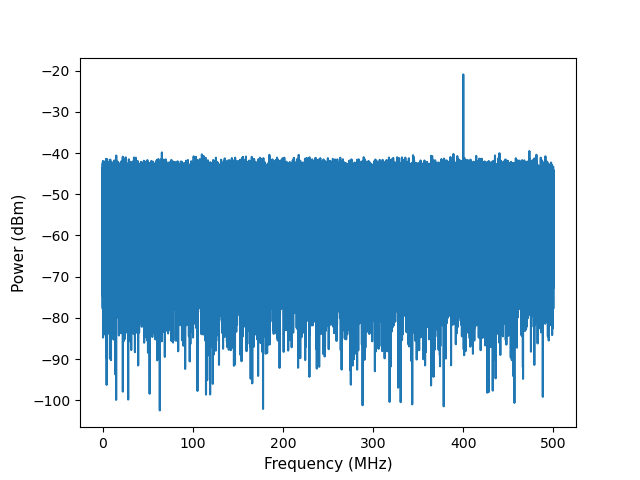

In [89]:
%matplotlib widget
fftLen = len(ADCVals)
freqData = (np.abs(np.fft.fft(ADCValsVolts, fftLen))[0:int(fftLen/2)+1])**2
freqData = freqData/fftLen**2
freqData = np.asarray([2*x if (counter > 0 and counter < int(fftLen/2)) else x for counter, x in enumerate(freqData)])

freqStep = sampFreq/fftLen
frequencies = np.asarray(range(0, int(fftLen/2)+1))*freqStep

freqDataLog = 10*np.log10(freqData*1000/50)

maxFreq = frequencies[np.argmax(freqDataLog[1:]) + 1]/10**6
print('MAX FREQUENCY AT ' + str(round(maxFreq, 6)) + ' MHz')
print('MAX BIN AT ' + str(np.argmax(freqDataLog[1:]) + 1))

if 1:
    plt.figure()
    plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
    plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
    plt.ylabel(r'Power (dBm)', **label_font)
    plt.show()
